# Прогнозирование качества вин


Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Для модели


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Загрузка CSV-файлов

In [ ]:
red_wine_path = '/content/winequality-red.csv'
white_wine_path = '/content/winequality-white.csv'

red_df = pd.read_csv(red_wine_path, sep=';')
white_df = pd.read_csv(white_wine_path, sep=';')

print('✅ Данные загружены')

✅ Данные загружены


Быстрый EDA: инфо и статистика


=== RED WINE ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.

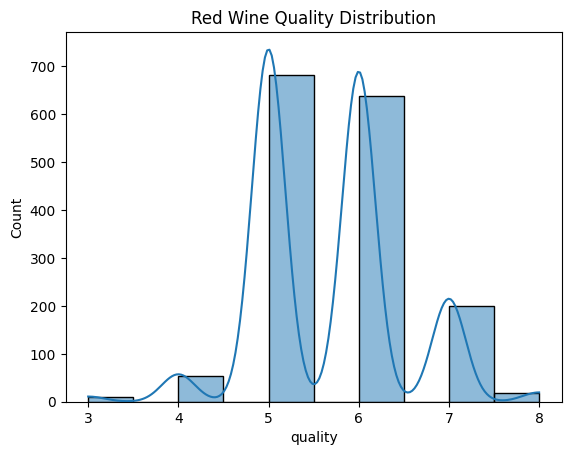


=== WHITE WINE ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       489

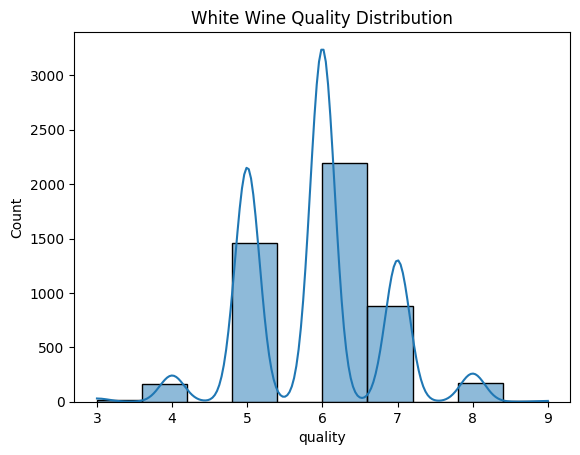

In [ ]:
def quick_eda(df, color):
    print(f"\n=== {color.upper()} WINE ===")
    print(df.info())
    print(df.describe())
    sns.histplot(df['quality'], bins=10, kde=True)
    plt.title(f'{color.title()} Wine Quality Distribution')
    plt.show()

quick_eda(red_df, 'red')
quick_eda(white_df, 'white')

Удаление выбросов (IQR)

In [ ]:
def remove_outliers(df, features, k=2.0, wine_type=""):
    initial_shape = df.shape[0]
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    removed = initial_shape - df.shape[0]
    print(f"{wine_type} вино: {removed} выбросов удалено (IQR={k})")
    return df
red_df = remove_outliers(red_df, features=red_df.columns[:-1], k=2.0, wine_type="Красное")
white_df = remove_outliers(white_df, features=white_df.columns[:-1], k=2.0, wine_type="Белое")


Красное вино: 48 выбросов удалено (IQR=2.0)
Белое вино: 570 выбросов удалено (IQR=2.0)


Нормализация признаков (кроме целевой переменной 'quality')

In [ ]:
scaler = MinMaxScaler()

def normalize_split(df):
    X = df.drop('quality', axis=1)
    y = df['quality']
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_r, X_test_r, y_train_r, y_test_r = normalize_split(red_df)
X_train_w, X_test_w, y_train_w, y_test_w = normalize_split(white_df)

print("✅ Нормализация и разбиение на train/test выполнено")



✅ Нормализация и разбиение на train/test выполнено


Создание модели

In [ ]:
def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


Обучение модели

In [ ]:
def train_model(X_train, y_train):
    model = build_model(X_train.shape[1])
    history = model.fit(X_train, y_train, validation_split=0.2,
                        epochs=100, batch_size=32, verbose=0)
    return model, history

Оценка и визуализация

In [ ]:
def evaluate_and_plot(model, X_test, y_test, wine_type):
    y_pred = model.predict(X_test).flatten()
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n🍷 {wine_type} Wine:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{wine_type} Wine: True vs Predicted Quality')
    plt.xlabel('True Quality')
    plt.ylabel('Predicted Quality')
    plt.show()

    return r2, mae


Красное вино

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

🍷 Red Wine:
R² Score: 0.2725
MAE: 0.4994


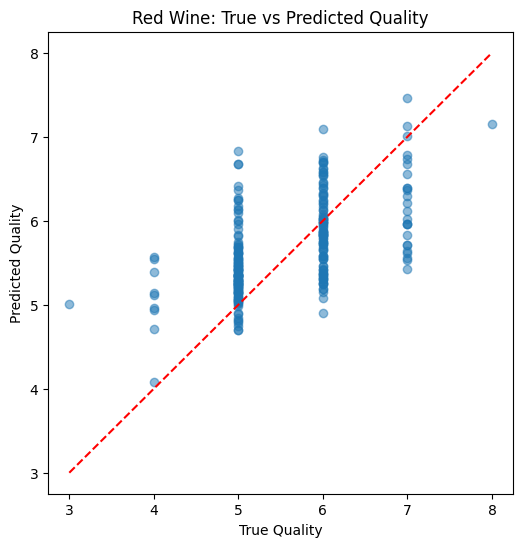

(0.2725013494491577, 0.4993772506713867)

In [ ]:
model_red, history_red = train_model(X_train_r, y_train_r)
evaluate_and_plot(model_red, X_test_r, y_test_r, "Red")


Белое вино

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

🍷 White Wine:
R² Score: 0.2792
MAE: 0.5418


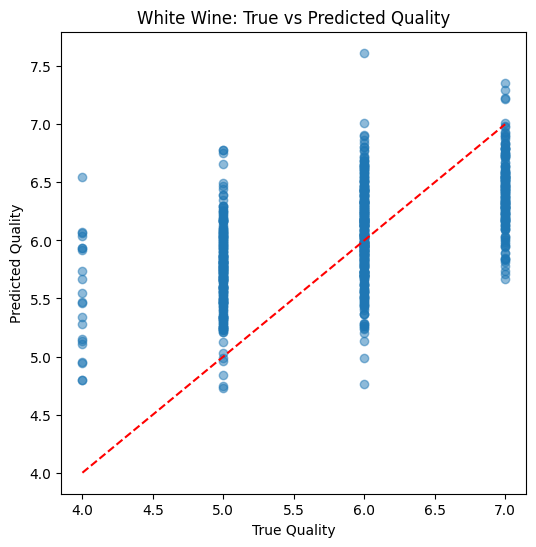

(0.27919459342956543, 0.5417753458023071)

In [ ]:
model_white, history_white = train_model(X_train_w, y_train_w)
evaluate_and_plot(model_white, X_test_w, y_test_w, "White")